In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
df_train = pd.read_csv('../../data/New dataset/Naive Bayes/train_tweets_Naive_Bayes_new.csv')
df_val = pd.read_csv('../../data/New dataset/Naive Bayes/eval_tweets_Naive_Bayes_new.csv')
df_test = pd.read_csv('../../data/New dataset/Naive Bayes/test_tweets_Naive_Bayes_new.csv')

# Validation dataset is not needed
df_train = pd.concat([df_train, df_val], ignore_index=True)

        term       tfidf
974    bully  317.490640
5415  school  275.599447
2575    fuck  250.261474
3710    like  200.377359
4292  nigger  196.997385
2668     get  194.380040
1986    dumb  194.232116
2707      go  183.564663
2686    girl  168.564034
3453    joke  167.975147
4644  people  162.261740
2959    high  157.685874
3852    make  138.893561
5395     say  137.450689
4432     one  133.233431
1018    call  131.053394
2632     gay  130.643118
5075    rape  130.402183
6818   would  121.421197
6793   woman  121.020487


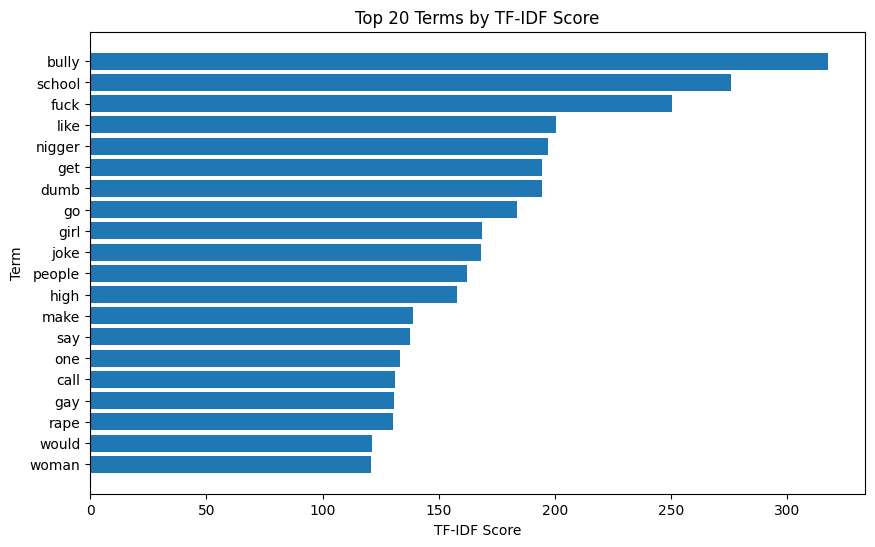

In [23]:

# Vectorizza i dati di testo usando TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
X_tfidf = vectorizer.fit_transform(df_train['tweet_text'])

# Somma i punteggi TF-IDF per ogni termine in tutti i documenti
tfidf_scores = X_tfidf.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()
tfidf_scores_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_scores})

# Verifica i termini con i punteggi TF-IDF più alti
print(tfidf_scores_df.sort_values(by='tfidf', ascending=False).head(20))

# Sort the DataFrame by TF-IDF scores in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by='tfidf', ascending=False)

# Plot the top 20 terms based on TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(tfidf_scores_df['term'].head(20)[::-1], tfidf_scores_df['tfidf'].head(20)[::-1])
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top 20 Terms by TF-IDF Score')
plt.show()


# Feature Selection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Definisci il pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5)),  # Estrazione delle caratteristiche
    ('sel', SelectKBest(mutual_info_classif)),  # Selezione delle caratteristiche
    ('learner', MultinomialNB())  # Algoritmo di apprendimento
])

# Definisci i parametri per la ricerca su griglia
param_grid = {
    'sel__k': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
}

# Configura la GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
X_train, y_train = df_train["tweet_text"], df_train["cyberbullying_type"]
X_test, y_test = df_test["tweet_text"], df_test["cyberbullying_type"]
# Esegui la grid search
grid_search.fit(X_train, y_train)

# Ottieni i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Estrai le metriche di performance
k_values = results['param_sel__k']
mean_test_score = results['mean_test_score']
std_test_score = results['std_test_score']

# Plotta le metriche di accuratezza
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_test_score, yerr=std_test_score, fmt='-o')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('Grid Search Accuracy Scores')
plt.show()

# Utilizza il miglior modello trovato per fare previsioni
best_model = grid_search.best_estimator_
bin_predictions = best_model.predict(X_test)

# Valuta il modello
print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

# Calcola precision, recall e f1 per ogni k
precision_scores = []
recall_scores = []
f1_scores = []

for k in param_grid['sel__k']:
    pipeline.set_params(sel__k=k)
    
    precision = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
    precision_scores.append(precision.mean())
    
    recall = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
    recall_scores.append(recall.mean())
    
    f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    f1_scores.append(f1.mean())

# Plotta precision, recall e f1
plt.figure(figsize=(10, 6))
plt.plot(param_grid['sel__k'], precision_scores, '-o', label='Precision')
plt.plot(param_grid['sel__k'], recall_scores, '-o', label='Recall')
plt.plot(param_grid['sel__k'], f1_scores, '-o', label='F1 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 Score vs Number of Features (k)')
plt.legend()
plt.show()


# Multiclass Naive Bayes Classifier

Function to perform cross validation.

In [15]:
def train_evaluate_model(train, test, vectorizer, classifier, title, binary = False):
    # Extract features and labels
    X_train, y_train = train["tweet_text"], train["cyberbullying_type"]
    X_test, y_test = test["tweet_text"], test["cyberbullying_type"]

    if binary:
        y_train = y_train.astype('int')
        y_test = y_test.astype('int')
    
    # Vectorize text data
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Train classifier
    classifier.fit(X_train, y_train)
        
    # Predict on test set
    y_pred = classifier.predict(X_test)
        
    # Generate classification report
    print(classification_report(y_test, y_pred))
    
    # Get the sorted list of unique class labels
    classes = sorted(train['cyberbullying_type'].unique())
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    
    # Plot confusion matrix with title
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Multinomial Naive Bayes Model
- Designed for discrete count-based data (e.g., text data represented by word frequency).	
- Features are counts of occurrences in different classes.
- Text classification, document categorization, sentiment analysis.

                   precision    recall  f1-score   support

              age       0.74      0.98      0.84      1568
        ethnicity       0.87      0.91      0.89      1502
           gender       0.89      0.83      0.86      1497
not_cyberbullying       0.88      0.37      0.52      1338
         religion       0.82      0.97      0.89      1614

         accuracy                           0.83      7519
        macro avg       0.84      0.81      0.80      7519
     weighted avg       0.84      0.83      0.81      7519



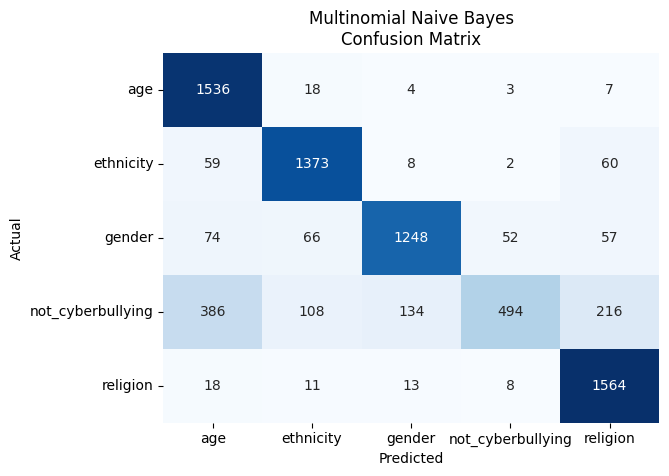

In [16]:

vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)


## Complement Naive Bayes Model
- Designed for categorical data with imbalanced classes.
- Features are represented by attribute frequencies in documents.
- Useful when classes are imbalanced and training data is limited.
- Used in text classification, document categorization, and reviews analysis applications.

                   precision    recall  f1-score   support

              age       0.80      0.97      0.87      1568
        ethnicity       0.87      0.93      0.90      1502
           gender       0.90      0.83      0.86      1497
not_cyberbullying       0.86      0.47      0.60      1338
         religion       0.84      0.98      0.90      1614

         accuracy                           0.85      7519
        macro avg       0.85      0.84      0.83      7519
     weighted avg       0.85      0.85      0.83      7519



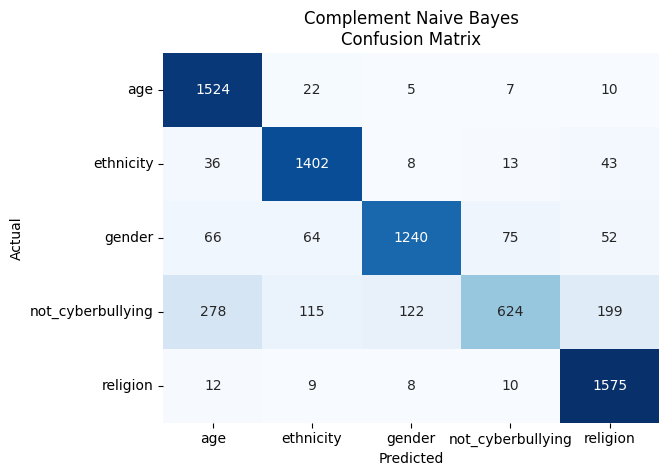

In [17]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)

## Bernoulli Naive Bayes Model

- Designed for discrete count-based data, such as text data represented by word frequency.
- Features are counts of occurrences in different classes.
- Commonly used in text classification, document categorization, and sentiment analysis tasks.

                   precision    recall  f1-score   support

              age       0.97      0.96      0.97      1568
        ethnicity       0.95      0.93      0.94      1502
           gender       0.92      0.81      0.86      1497
not_cyberbullying       0.74      0.85      0.79      1338
         religion       0.91      0.93      0.92      1614

         accuracy                           0.90      7519
        macro avg       0.90      0.90      0.90      7519
     weighted avg       0.90      0.90      0.90      7519



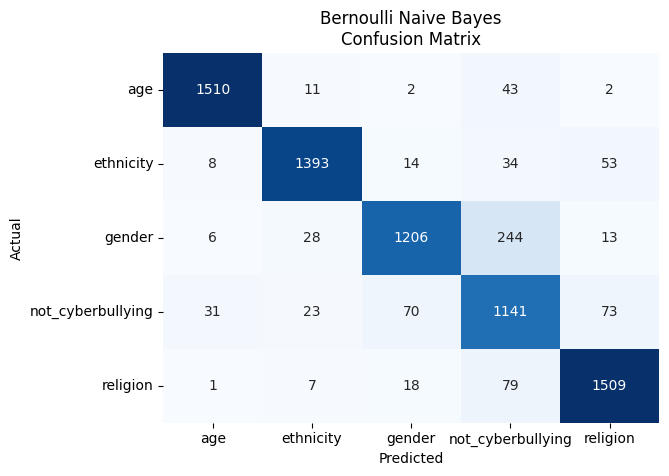

In [18]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Bernoulli Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title)

# Binary Naive Bayes Classifier

From the original dataset, we selected all the tweets labeled as "not_cyberbullying" and assigned them the category 1. Since there were 7815 such tweets, to achieve a balanced distribution, we selected 1563 tweets for each cyberbullying category and assigned them label 0.

In [19]:
def balanced_dataset(df):

    class_counts = df['cyberbullying_type'].value_counts()
    n = class_counts['not_cyberbullying'] 
    n = int(n / 4)

    # Create an empty dataframe for the results
    result_df = pd.DataFrame(columns=['tweet_text', 'cyberbullying_type'])

    for category in df['cyberbullying_type'].unique():
        if category != 'not_cyberbullying':
            sampled_df = df[df['cyberbullying_type'] == category].sample(n=n, replace=False)
            sampled_df.loc[:, 'cyberbullying_type'] = 0  
            result_df = pd.concat([result_df, sampled_df[['tweet_text', 'cyberbullying_type']]], ignore_index=True)
        else:
            other_cyberbullying_df = df[df['cyberbullying_type'] == category].copy() 
            other_cyberbullying_df.loc[:, 'cyberbullying_type'] = 1 
            result_df = pd.concat([result_df, other_cyberbullying_df[['tweet_text', 'cyberbullying_type']]], ignore_index=True)
    
    return result_df

df_train = balanced_dataset(df_train)
df_test = balanced_dataset(df_test)

## Multinomial Naive Bayes Model

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1336
           1       0.93      0.67      0.78      1338

    accuracy                           0.81      2674
   macro avg       0.83      0.81      0.80      2674
weighted avg       0.83      0.81      0.80      2674



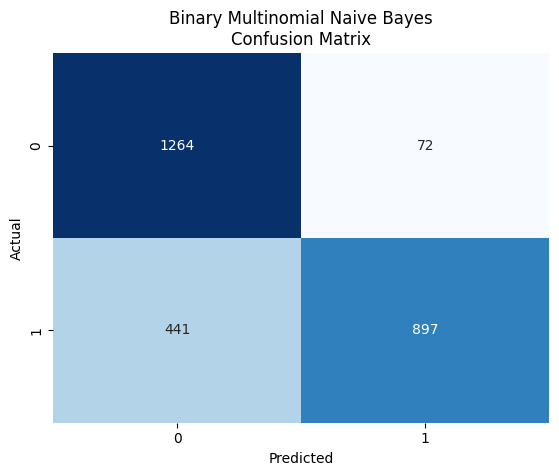

In [20]:
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Binary Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title, binary = True)

## Complement Naive Bayes Model

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1336
           1       0.93      0.67      0.78      1338

    accuracy                           0.81      2674
   macro avg       0.83      0.81      0.80      2674
weighted avg       0.83      0.81      0.80      2674



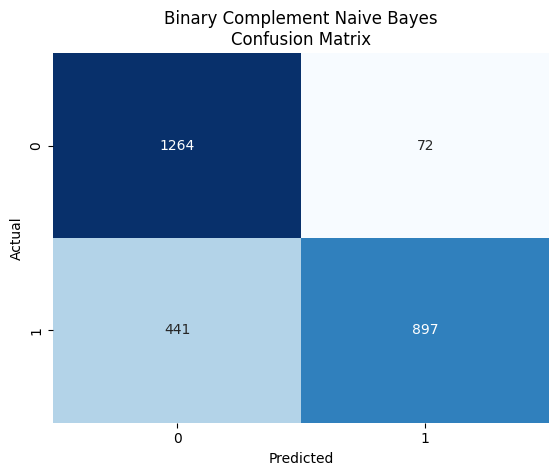

In [21]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Binary Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title, binary = True)

## Bernoulli Naive Bayes Model

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1336
           1       0.88      0.92      0.90      1338

    accuracy                           0.90      2674
   macro avg       0.90      0.90      0.90      2674
weighted avg       0.90      0.90      0.90      2674



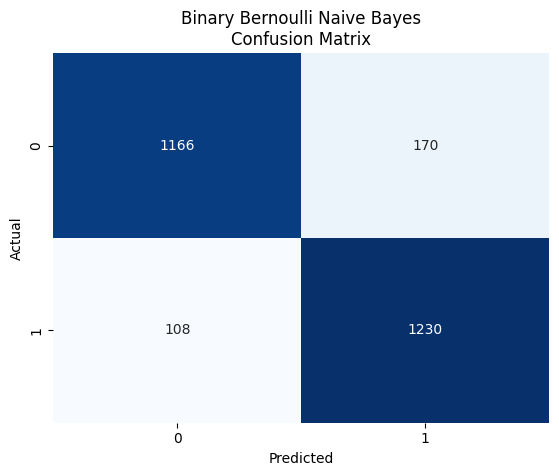

In [22]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Binary Bernoulli Naive Bayes\nConfusion Matrix'
train_evaluate_model(df_train, df_test, vectorizer, classifier, title, binary = True)